# Deteccion de anomalias

- Dataset: Facturas con detalle RIPS

In [1]:
# !pip install numpy==2.1
# !pip install tqdm scikit-learn
# !pip install pyod
# !pip install torch
# !pip install .\..\..\..\anomaly_tesis_library\whl\lib_anomaly-1.1-py2.py3-none-any.whl --force-reinstall --no-dependencies

In [2]:
# prestador = "0DD90F985DE9C9863A8073BB6BEDBED0"
# prestador = "43246AB2ECE09E419D3C7D7C1D33C33B"
# prestador = "4F09BB7381F2DD5BE74AEB854852AEFD"
# prestador = "E0B158A4D09C4884A37BAA919DC7EB47"
# prestador = "3F89EB097CB8FB95E71536FCE8F04D40"
# prestador = "BDC9655DB70D0AD154FA9811931FC6C8"
# prestador = "5833AB66972CC785431A16BE6CCD2C47"
prestador = "0DD90F985DE9C9863A8073BB6BEDBED0"

filtro = [("PRESTADOR", "=", prestador)]
filtro

[('PRESTADOR', '=', '0DD90F985DE9C9863A8073BB6BEDBED0')]

In [3]:
## Librerias necesarias 

import time
start_i = time.time()

import datetime, os, gc, warnings

import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from datatools.helpers.Utils import normalize_str, format_df, run_time

Para preprocesar

In [4]:
from sklearn.pipeline           import Pipeline
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import MinMaxScaler, OneHotEncoder
from sklearn.compose            import ColumnTransformer
from sklearn.decomposition      import PCA as pca_

In [5]:
from lib_anomaly.anomaly        import make_hidden_layers

from pyod.models.pca            import PCA
from pyod.models.lof            import LOF
from pyod.models.iforest        import IForest
from pyod.models.auto_encoder   import AutoEncoder

In [6]:
## config 
pd.options.display.max_columns  = 200
pd.options.display.max_rows     = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

### Funciones

In [7]:
class PreprocessPipeline:

    """Preprocessing pipeline for numerical and categorical data."""
    
    def __init__(self, **kwargs):
        """
        Initialize the preprocessing pipeline.
        
        Args:
            numerical_cols (list): List of column names for numerical features.
            categorical_cols (list): List of column names for categorical features.
        """

        ## parametros
        try:
            self.numerical_cols = kwargs["numerical_cols"]
        except:
            self.numerical_cols = list()
        try:
            self.categorical_cols = kwargs["categorical_cols"]
        except:
            self.categorical_cols = list()
        try:
            self.categorical_cols_high = kwargs["categorical_cols_high"]
        except:
            self.categorical_cols_high = list()
        try:
            self.n_components = kwargs["n_components"]
        except:
            self.n_components = list()

        self.preporcessor = self._make_preprocessor()

    def _make_preprocessor(self):
        numeric_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean'))
            , ('scaler', MinMaxScaler((0,1)))
        ])
        categorical_pipeline = Pipeline([
            ('pd.NA', SimpleImputer(missing_values=pd.NA, strategy='most_frequent'))
            , ('np.nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
            , ('None', SimpleImputer(missing_values=None, strategy='most_frequent'))
            , ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])
        preprocessor_pipe = ColumnTransformer(
            transformers=[
                ('num', numeric_pipeline, self.numerical_cols)
                , ('cat', categorical_pipeline, self.categorical_cols)
            ])
        return preprocessor_pipe

    def transform(self, data):
        transformed_data = self.preporcessor.fit_transform(data)
        transformed_data = pd.DataFrame(transformed_data, columns=self.preporcessor.get_feature_names_out())
        # transformed_data = self.transform_cols_high(transformed_data, categorical_cols_high)
        if len(self.categorical_cols_high)>0:
            df_pca = pd.DataFrame()
            for c in self.categorical_cols_high:
                busq = f"cat__{c}_"
                cols = [c for c in transformed_data if c.startswith(busq)]
                print(f"{busq=}, {len(cols)=}")
                aa = pca_(n_components=self.n_components).fit_transform(transformed_data[cols])
                aa = pd.DataFrame(aa, index=transformed_data.index, columns=[f"{c}__PC{str(i+1).zfill(2)}" for i in range(self.n_components)])
                df_pca = pd.concat([df_pca, aa], axis=1)
                print(f"{aa.shape=}")
                transformed_data = transformed_data.drop(cols, axis=1)
                print(f"{transformed_data.shape=}")
            df_pca = pd.DataFrame(MinMaxScaler((0,1)).fit_transform(df_pca), index=df_pca.index, columns=df_pca.columns)
            transformed_data = pd.concat([transformed_data,df_pca], axis=1)
        transformed_data.index = data.index
        return transformed_data

    

Anomaly

In [8]:
def get_dtypes(data:pd.DataFrame, debug:bool=False):
    numerical_cols = list(data.select_dtypes(include=['number']).columns)
    categorical_cols = list(data.select_dtypes(exclude=['number']).columns)
    if debug==True: print(f"{numerical_cols=}\n{categorical_cols=}")
    categorical_cols_high = list(data[categorical_cols].nunique()[data[categorical_cols].nunique()>15].index)
    if "departamento" in categorical_cols_high:
        categorical_cols_high = [c for c in categorical_cols_high if c!="departamento"]
    categorical_cols_low  = [c for c in categorical_cols if c not in categorical_cols_high]
    if debug==True: print(f"{categorical_cols_high=}\n{categorical_cols_low=}")
    return numerical_cols, categorical_cols, categorical_cols_high, categorical_cols_low

In [9]:
def make_ensamble(df:pd.DataFrame, anomaly_methods:list, anomaly_threshold:float, debug:bool=False):
    
    ### Ensamble
    name_detector = "Ensamble"
    df[name_detector] = df[anomaly_methods].sum(axis=1)
    df[name_detector+"__prob"] = df[[c+"__prob" for c in anomaly_methods]].mean(axis=1)
    df[name_detector+"__prob_std"] = df[[c+"__prob" for c in anomaly_methods]].std(axis=1)
    # anom__prob = data[name_detector+"__prob"].reset_index(drop=True).values
    # anom_index = [i for i,a in enumerate(data[name_detector+"__prob"]) if a>data[name_detector+"__prob"].quantile(1-contamination)]
    # df.loc[:,"LOF":].describe().T
    
    # make_ensamble_anomaly_detector_by_threshold
    name_detector = f"Ensamble P({anomaly_threshold})"
    df[name_detector] = df["Ensamble__prob"]>anomaly_threshold
    df[name_detector] = df[name_detector].astype(int)
    
    # ensamble wiith treshold
    name_detector = f"Ensamble P({anomaly_threshold})"
    df[name_detector] = df["Ensamble__prob"]>anomaly_threshold
    df[name_detector] = df[name_detector].astype(int)
    
    return df

In [10]:
def make_position(df:pd.DataFrame, anomaly_methods:list):
    df = df.reset_index()
    for met in anomaly_methods+["Ensamble"]:
        try:
            df = df.sort_values(met+"__score", ascending=False).reset_index(drop=True).reset_index().rename(columns={"index":met+"__pos"})
        except:
            df = df.sort_values(met+"__prob", ascending=False).reset_index(drop=True).reset_index().rename(columns={"index":met+"__pos"})
    cols = [c for c in df if c.endswith("__pos")]
    df[cols] = df[cols] + 1
    df = pd.concat([df.drop(cols, axis=1), df[cols]], axis=1).set_index("id")
    return df

In [11]:
def run_anomaly_detectors(data:pd.DataFrame, X:np.ndarray, anomaly_methods:list, contamination:float, anomaly_threshold:float, debug:bool=False):
    """
        Ejecuta la deteccion de las anomalias a traves de los metodos pasados
        Arroja si el registro es marcado como anomalo o no, al igual que la probabilidad
    """
    data = data.copy()
    for name_detector in anomaly_methods:
        start = time.time()
        if debug==True: print(f"**************\nstarting: {name_detector}, {contamination=}")
        if name_detector=="AutoEncoder":
            nn_layers = make_hidden_layers(no_features=X.shape[1])
            if debug==True: print(f"{nn_layers=}")
            try:
                detector = eval(f"{name_detector}(hidden_neurons={nn_layers}, verbose=0, contamination={contamination})")
            except:
                detector = eval(f"{name_detector}(hidden_neuron_list={nn_layers}, verbose=0, contamination={contamination})")
        else:
            detector = eval(f"{name_detector}(contamination={contamination})")
        detector.fit(X)
        data[name_detector] = detector.labels_
        data[f"{name_detector}__score"] = detector.decision_function(X)
        data[f"{name_detector}__prob"]  = detector.predict_proba(X)[:,1]
        if debug==True: print(f"No of anomaly = {sum(data[name_detector])}({round(sum(data[name_detector])/len(data[name_detector])*100,4)}%)")
        if debug==True: print(f"anom distribution; {dict(data[name_detector].value_counts().sort_index())}, {dict(data[name_detector].value_counts(normalize=True).sort_index())}")
        if debug==True: print(f"Run: {(time.time()-start)/60:.2f} min.")
    gc.collect()
    
    df = make_ensamble(
                    df=data
                    , anomaly_methods=anomaly_methods
                    , anomaly_threshold=anomaly_threshold
                    , debug=debug
                )
    df = make_position(
                    df=df
                    , anomaly_methods=anomaly_methods
                )
    df = df.loc[data.index]
    return df

In [12]:
def add_anomaly_2_raw(raw, transformed_data, df_anom):
    """
        raw     : Df original
        transformed_data      : Df con transformaciones
        df_anom : Df con detecciones de anomalias
    """
    cols1 = [c for c in df_anom if c not in raw]
    cols2 = [c for c in transformed_data if c not in list(raw.columns)+cols1]
    df_ = pd.concat([
                    raw
                    , transformed_data.loc[raw.index,cols2]
                    , df_anom.loc[raw.index,cols1]
                ], axis=1)
    df_.columns = [normalize_str(c, ("__")) for c in df_]
    return df_

In [13]:
def get_stats(df:pd.DataFrame):
    colums_stats = pd.concat([df.dtypes, df.count(), df.nunique(), df.isnull().sum(), (df.isnull().sum()/len(df))], axis=1)
    colums_stats.columns = ["dtypes", "#reg", "nunique","nulls","%nulls"]
    colums_stats = pd.concat([colums_stats, df.describe().T], axis=1)
    return colums_stats

# Seleccion de los datos

In [14]:
%%time

## load data
fName = "../../4. creacion de dataset/dataset facturas/output/dataset.parquet"
data = pd.read_parquet(fName, filters=filtro)
data.columns = [normalize_str(c) for c in data]
data = data.set_index("id")
print(f"{prestador=}, {data.shape=}")
# data.iloc[0]

prestador='0DD90F985DE9C9863A8073BB6BEDBED0', data.shape=(424615, 115)
CPU times: total: 25.3 s
Wall time: 17.3 s


### Filtros
- valor_factura > 1000
- personas_unicas > 0
- registros en RIPS > 0

In [15]:
filtro1 = (data["valor_factura"]>1000)
filtro2 = (data["personas_unicas"]>0)
filtro3 = (data[[c for c in data if c.startswith("reg_")]].sum(axis=1)>0)
print("filtro1 =", dict(filtro1.value_counts(normalize=True).sort_index(ascending=False)*100))
print("filtro2 =", dict(filtro2.value_counts(normalize=True).sort_index(ascending=False)*100))
print("filtro3 =", dict(filtro3.value_counts(normalize=True).sort_index(ascending=False)*100))

print("-"*50)
filtro = filtro1 & filtro2 & filtro3
print("Filtro final =", dict(filtro.value_counts(normalize=True).sort_index(ascending=False)*100))
print("Se descartan los 'Falsos'")
pd.concat([filtro.value_counts().sort_index(ascending=False), filtro.value_counts(normalize=True).sort_index(ascending=False)*100], axis=1)


filtro1 = {True: 98.95811499829257, False: 1.041885001707429}
filtro2 = {True: 100.0}
filtro3 = {True: 86.05772287837216, False: 13.942277121627827}
--------------------------------------------------
Filtro final = {True: 85.02243208553631, False: 14.977567914463691}
Se descartan los 'Falsos'


,count,proportion
True,361018,85.022432
False,63597,14.977568


In [16]:
## aplica el filtro
data = data[filtro].copy()
print(f"{data.shape=}")

data.shape=(361018, 115)


### Ejemplo de segmentacion por un prestador
- permite identificar los diferentes comportamientos de las atenciones
- la vaiabilidad deberia ser menor por que corresponde toda la info al mismo prestador


In [17]:
try:
    os.makedirs(f"./output/{prestador}/")
except:
    pass

Seleccionando un prestador

In [18]:
fName = f"./output/{prestador}/raw.parquet"
try:
    raw = pd.read_parquet(fName)
except:
    # raw = data[data["prestador"]==prestador].drop(["prestador","factura","id_carga"], axis=1)
    raw = data.drop(["prestador","factura","id_carga"], axis=1)
    raw.to_parquet(fName)
print(f"{fName=}\n{raw.shape=}")

raw.head()

fName='./output/0DD90F985DE9C9863A8073BB6BEDBED0/raw.parquet'
raw.shape=(361018, 41)


,periodo_fin_ano,periodo_fin_mes,duracion_facturacion,contrato,valor_copago,valor_descuentos,valor_factura,personas_unicas,mujeres,hombres,personas_rural,personas_c,edad_avg,edad_std,edad_p50,reg_med,personas_unicas_con_med,mujeres_con_med,menores_con_med,avg_personas_con_med,num_med_mujeres,num_med_menores,num_med_rurales,num_med,num_med_nopbs,med_pbs_cantidad,avg_med_pbs_cantidad,std_med_pbs_cantidad,p50_med_pbs_cantidad,med_pbs_valor,avg_med_pbs_valor,std_med_pbs_valor,p50_med_pbs_valor,med_nopbs_cantidad,avg_med_nopbs_cantidad,std_med_nopbs_cantidad,p50_med_nopbs_cantidad,med_nopbs_valor,avg_med_nopbs_valor,std_med_nopbs_valor,p50_med_nopbs_valor
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D1705BF90ACB4583339A5F6BBED5A4C5-852126,2021,10,0.032856,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,87192.0,307,187,120,0,0,54.110749,25.268637,61.0,1,1,0,0,44.0,0,0,0,1,0,56.0,56.0,0.0,56.0,87192.0,1557.0,0.000000,1557.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370E0DD7AE83F3537F02F2AA80E1DD24-556158,2021,2,1.905540,FE63394A58C6DBE758731799A1022802,0.0,0.0,113220.0,1408,888,520,0,0,47.657670,25.696537,55.0,1,1,1,0,90.0,1,0,0,1,0,30.0,30.0,0.0,30.0,113220.0,3774.0,0.000000,3774.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1F9AA689BB1B03F4E8469A896BC67AE5-506452,2021,1,4.665300,4B9BB01F3B4C1344BF7C4B4DBD9F3E6D,0.0,0.0,4775.0,2467,1475,992,0,0,50.287799,24.300061,57.0,2,1,1,1,1.0,2,2,0,2,0,2.0,1.0,0.0,1.0,4775.0,2387.5,543.765115,2387.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6451E795C14D1EC5611DE4E8693C4D41-729094,2021,8,0.032856,FE63394A58C6DBE758731799A1022802,0.0,0.0,90188.0,466,287,179,0,36,57.006438,19.449907,61.0,1,1,1,0,69.0,1,0,0,1,0,28.0,28.0,0.0,28.0,90188.0,3221.0,0.000000,3221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4210F933D2F6EC5DA10527BE5144A58A-567105,2021,3,4.895280,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,184380.0,1434,903,531,0,0,58.251046,25.342368,65.0,1,1,1,0,86.0,1,0,0,1,0,28.0,28.0,0.0,28.0,184380.0,6585.0,0.000000,6585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print("estadisticas del df:")
df_stats = get_stats(raw)
format_df(df_stats)

estadisticas del df:


,dtypes,#reg,nunique,nulls,%nulls,count,mean,std,min,25%,50%,75%,max
periodo_fin_ano,int16,"361,018",3,0,0.00%,"361,018","2,021",1,"2,020","2,021","2,021","2,022","2,022"
periodo_fin_mes,int8,"361,018",12,0,0.00%,"361,018",7,3,1,4,7,9,12
duracion_facturacion,float64,"361,018",122,0,0.00%,"361,018",1,2,0,0,0,0,16
contrato,object,"361,018",52,0,0.00%,nan,nan,nan,nan,nan,nan,nan,nan
valor_copago,float64,"361,018",42,0,0.00%,"361,018",138,938,0,0,0,0,"38,500"
valor_descuentos,float64,"361,018",128,0,0.00%,"361,018",49,"5,601",0,0,0,0,"2,717,232"
valor_factura,float64,"361,018","29,913",0,0.00%,"361,018","296,229","10,115,307","1,001","12,600","48,192","119,190","1,656,038,682"
personas_unicas,int32,"361,018",757,0,0.00%,"361,018",529,839,1,92,244,483,"46,942"
mujeres,int32,"361,018",555,0,0.00%,"361,018",329,520,0,58,154,313,"31,168"
hombres,int32,"361,018",466,0,0.00%,"361,018",200,322,0,33,90,185,"15,774"


Descartar columnas que solo tienen un dato diferente, o toda la columan tiene el mismo valor.

In [20]:
cols_2_drop = list(df_stats[df_stats["nunique"]==1].index)
print(f"# de columnas a descartar = {len(cols_2_drop)}")
cols_2_drop

# de columnas a descartar = 0


[]

In [21]:
df = raw.drop(cols_2_drop, axis=1)
print(f"El dataframe pasa de {raw.shape[1]} a {df.shape[1]} (reduccion del {1-df.shape[1]/raw.shape[1]:.2%}), descartando {len(cols_2_drop)} columnas.")
df.head()

El dataframe pasa de 41 a 41 (reduccion del 0.00%), descartando 0 columnas.


,periodo_fin_ano,periodo_fin_mes,duracion_facturacion,contrato,valor_copago,valor_descuentos,valor_factura,personas_unicas,mujeres,hombres,personas_rural,personas_c,edad_avg,edad_std,edad_p50,reg_med,personas_unicas_con_med,mujeres_con_med,menores_con_med,avg_personas_con_med,num_med_mujeres,num_med_menores,num_med_rurales,num_med,num_med_nopbs,med_pbs_cantidad,avg_med_pbs_cantidad,std_med_pbs_cantidad,p50_med_pbs_cantidad,med_pbs_valor,avg_med_pbs_valor,std_med_pbs_valor,p50_med_pbs_valor,med_nopbs_cantidad,avg_med_nopbs_cantidad,std_med_nopbs_cantidad,p50_med_nopbs_cantidad,med_nopbs_valor,avg_med_nopbs_valor,std_med_nopbs_valor,p50_med_nopbs_valor
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D1705BF90ACB4583339A5F6BBED5A4C5-852126,2021,10,0.032856,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,87192.0,307,187,120,0,0,54.110749,25.268637,61.0,1,1,0,0,44.0,0,0,0,1,0,56.0,56.0,0.0,56.0,87192.0,1557.0,0.000000,1557.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370E0DD7AE83F3537F02F2AA80E1DD24-556158,2021,2,1.905540,FE63394A58C6DBE758731799A1022802,0.0,0.0,113220.0,1408,888,520,0,0,47.657670,25.696537,55.0,1,1,1,0,90.0,1,0,0,1,0,30.0,30.0,0.0,30.0,113220.0,3774.0,0.000000,3774.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1F9AA689BB1B03F4E8469A896BC67AE5-506452,2021,1,4.665300,4B9BB01F3B4C1344BF7C4B4DBD9F3E6D,0.0,0.0,4775.0,2467,1475,992,0,0,50.287799,24.300061,57.0,2,1,1,1,1.0,2,2,0,2,0,2.0,1.0,0.0,1.0,4775.0,2387.5,543.765115,2387.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6451E795C14D1EC5611DE4E8693C4D41-729094,2021,8,0.032856,FE63394A58C6DBE758731799A1022802,0.0,0.0,90188.0,466,287,179,0,36,57.006438,19.449907,61.0,1,1,1,0,69.0,1,0,0,1,0,28.0,28.0,0.0,28.0,90188.0,3221.0,0.000000,3221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4210F933D2F6EC5DA10527BE5144A58A-567105,2021,3,4.895280,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,184380.0,1434,903,531,0,0,58.251046,25.342368,65.0,1,1,1,0,86.0,1,0,0,1,0,28.0,28.0,0.0,28.0,184380.0,6585.0,0.000000,6585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Limpieza de cols_2_drop

In [22]:
df_stats = df_stats.drop(cols_2_drop)
df_stats

,dtypes,#reg,nunique,nulls,%nulls,count,mean,std,min,25%,50%,75%,max
periodo_fin_ano,int16,361018,3,0,0.0,361018.0,2021.340556,6.690527e-01,2020.000000,2021.000000,2021.000000,2022.000000,2.022000e+03
periodo_fin_mes,int8,361018,12,0,0.0,361018.0,6.650790,3.285250e+00,1.000000,4.000000,7.000000,9.000000,1.200000e+01
duracion_facturacion,float64,361018,122,0,0.0,361018.0,0.747953,2.171705e+00,0.032856,0.032856,0.032856,0.032856,1.639426e+01
contrato,object,361018,52,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
valor_copago,float64,361018,42,0,0.0,361018.0,138.062038,9.384338e+02,0.000000,0.000000,0.000000,0.000000,3.850000e+04
valor_descuentos,float64,361018,128,0,0.0,361018.0,48.811507,5.600993e+03,0.000000,0.000000,0.000000,0.000000,2.717232e+06
valor_factura,float64,361018,29913,0,0.0,361018.0,296229.232889,1.011531e+07,1001.000000,12600.000000,48192.000000,119190.000000,1.656039e+09
personas_unicas,int32,361018,757,0,0.0,361018.0,529.209297,8.387603e+02,1.000000,92.000000,244.000000,483.000000,4.694200e+04
mujeres,int32,361018,555,0,0.0,361018.0,328.803849,5.196971e+02,0.000000,58.000000,154.000000,313.000000,3.116800e+04
hombres,int32,361018,466,0,0.0,361018.0,200.405448,3.223546e+02,0.000000,33.000000,90.000000,185.000000,1.577400e+04


In [23]:
try:
    format_df(
            df.agg(
            factura=("contrato","size")
            , valor_factura=("valor_factura","sum")
        ).max().to_frame().T
    )
except Exception as e:
    print("ERROR:", e)

In [24]:
try:
    print(f"Total por el {prestador=}:")
    format_df(
            df.agg(
                facturas=("contrato","size")
                , valor_factura=("valor_factura","sum")
                , contratos=("contrato","nunique")
            ).max(axis=1).to_frame().T.assign(
                        valor_prom_factura=lambda x: x["valor_factura"]/x["facturas"]
                    )
    )
except Exception as e:
    print("ERROR:", e)

Total por el prestador='0DD90F985DE9C9863A8073BB6BEDBED0':


In [25]:
try:
    print("Total por contratos:")
    format_df(df.groupby(["contrato"],dropna=False).agg(
        facturas=("contrato","size")
        , valor_factura=("valor_factura","sum")
            ).assign(
                valor_prom_factura=lambda x: x["valor_factura"]/x["facturas"]
    ))
except Exception as e:
    print("ERROR:", e)

Total por contratos:


## Preprocesamiento

- determinacion de columnas

In [26]:
print(f"Input {raw.shape=}")
numerical_cols, categorical_cols, categorical_cols_high, categorical_cols_low = get_dtypes(
                                                                                            data=raw
                                                                                            , debug=True
                                                                                        )

Input raw.shape=(361018, 41)
numerical_cols=['periodo_fin_ano', 'periodo_fin_mes', 'duracion_facturacion', 'valor_copago', 'valor_descuentos', 'valor_factura', 'personas_unicas', 'mujeres', 'hombres', 'personas_rural', 'personas_c', 'edad_avg', 'edad_std', 'edad_p50', 'reg_med', 'personas_unicas_con_med', 'mujeres_con_med', 'menores_con_med', 'avg_personas_con_med', 'num_med_mujeres', 'num_med_menores', 'num_med_rurales', 'num_med', 'num_med_nopbs', 'med_pbs_cantidad', 'avg_med_pbs_cantidad', 'std_med_pbs_cantidad', 'p50_med_pbs_cantidad', 'med_pbs_valor', 'avg_med_pbs_valor', 'std_med_pbs_valor', 'p50_med_pbs_valor', 'med_nopbs_cantidad', 'avg_med_nopbs_cantidad', 'std_med_nopbs_cantidad', 'p50_med_nopbs_cantidad', 'med_nopbs_valor', 'avg_med_nopbs_valor', 'std_med_nopbs_valor', 'p50_med_nopbs_valor']
categorical_cols=['contrato']
categorical_cols_high=['contrato']
categorical_cols_low=[]


In [27]:
## mantener las columnas categorias high como low

# categorical_cols_low    = categorical_cols_high.copy()
# categorical_cols_high   = list()
# print(f"{numerical_cols=}\n{categorical_cols_low=}\n{categorical_cols_high=}")

In [28]:
n_components = 3

PrePipeline = PreprocessPipeline(
                                    numerical_cols=numerical_cols
                                    , categorical_cols=categorical_cols
                                    , categorical_cols_high=categorical_cols_high
                                    , n_components=n_components
                                )
PrePipeline._make_preprocessor()

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['periodo_fin_ano', 'periodo_fin_mes',
                                  'duracion_facturacion', 'valor_copago',
                                  'valor_descuentos', 'valor_factura',
                                  'personas_unicas', 'mujeres', 'hombres',
                                  'personas_rural', 'personas_c', 'edad_avg',
                                  'edad_std', 'edad_p50', 'reg_med',
                                  'personas_unicas_c...
                                  'p50_med_pbs_cantidad', 'med_pbs_valor',
                                  'avg_med_pbs_valor', ...]),
                                ('cat',
                                 Pipeline(steps=[('pd.NA',
                                                  SimpleImputer(missing_values=<NA>,
                                                                strategy='most_frequent')),
                                                 ('np.nan',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('None',
                                                  SimpleImputer(missing_values=None,
                                                                strategy='most_frequent')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['contrato'])])

In [29]:
## aplica preprocesador a los datos

transformed_data = PrePipeline.transform(data=raw)
print(f"{transformed_data.shape=}")
transformed_data.head()

busq='cat__contrato_', len(cols)=52
aa.shape=(361018, 3)
transformed_data.shape=(361018, 40)
transformed_data.shape=(361018, 43)


,num__periodo_fin_ano,num__periodo_fin_mes,num__duracion_facturacion,num__valor_copago,num__valor_descuentos,num__valor_factura,num__personas_unicas,num__mujeres,num__hombres,num__personas_rural,num__personas_c,num__edad_avg,num__edad_std,num__edad_p50,num__reg_med,num__personas_unicas_con_med,num__mujeres_con_med,num__menores_con_med,num__avg_personas_con_med,num__num_med_mujeres,num__num_med_menores,num__num_med_rurales,num__num_med,num__num_med_nopbs,num__med_pbs_cantidad,num__avg_med_pbs_cantidad,num__std_med_pbs_cantidad,num__p50_med_pbs_cantidad,num__med_pbs_valor,num__avg_med_pbs_valor,num__std_med_pbs_valor,num__p50_med_pbs_valor,num__med_nopbs_cantidad,num__avg_med_nopbs_cantidad,num__std_med_nopbs_cantidad,num__p50_med_nopbs_cantidad,num__med_nopbs_valor,num__avg_med_nopbs_valor,num__std_med_nopbs_valor,num__p50_med_nopbs_valor,contrato__PC01,contrato__PC02,contrato__PC03
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D1705BF90ACB4583339A5F6BBED5A4C5-852126,0.5,0.818182,0.000000,0.0,0.0,0.000052,0.006519,0.006000,0.007607,0.0,0.000000,0.569587,0.392695,0.642105,0.000000,0.0,0.000000,0.000000,0.415094,0.000000,0.000000,0.0,0.000000,0.0,8.263580e-06,0.116667,0.0,0.116667,0.000052,0.000049,0.000000,0.000049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,5.242673e-11,0.488176
370E0DD7AE83F3537F02F2AA80E1DD24-556158,0.5,0.090909,0.114457,0.0,0.0,0.000068,0.029974,0.028491,0.032966,0.0,0.000000,0.501660,0.399345,0.578947,0.000000,0.0,0.000032,0.000000,0.849057,0.000006,0.000000,0.0,0.000000,0.0,4.426918e-06,0.062500,0.0,0.062500,0.000068,0.000118,0.000000,0.000118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.551115e-17,4.155472e-01,0.493691
1F9AA689BB1B03F4E8469A896BC67AE5-506452,0.5,0.000000,0.283132,0.0,0.0,0.000002,0.052534,0.047324,0.062888,0.0,0.000000,0.529345,0.377643,0.600000,0.000004,0.0,0.000032,0.000077,0.009434,0.000011,0.000043,0.0,0.000892,0.0,2.951279e-07,0.002083,0.0,0.002083,0.000003,0.000075,0.000065,0.000075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.132168e-01,8.313995e-01,0.529178
6451E795C14D1EC5611DE4E8693C4D41-729094,0.5,0.636364,0.000000,0.0,0.0,0.000054,0.009906,0.009208,0.011348,0.0,0.000767,0.600068,0.302267,0.642105,0.000000,0.0,0.000032,0.000000,0.650943,0.000006,0.000000,0.0,0.000000,0.0,4.131790e-06,0.058333,0.0,0.058333,0.000054,0.000101,0.000000,0.000101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,4.155472e-01,0.493691
4210F933D2F6EC5DA10527BE5144A58A-567105,0.5,0.181818,0.297189,0.0,0.0,0.000111,0.030528,0.028972,0.033663,0.0,0.000000,0.613169,0.393841,0.684211,0.000000,0.0,0.000032,0.000000,0.811321,0.000006,0.000000,0.0,0.000000,0.0,4.131790e-06,0.058333,0.0,0.058333,0.000111,0.000206,0.000000,0.000206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,0.000000e+00,0.488176


Por default la clase devuelve el tipo de dato concatenado del nombre de la variable, por ejemplo si la columna se llama "valor_factura" devuelve "num__valor_factura"

In [30]:
transformed_data.columns

Index(['num__periodo_fin_ano', 'num__periodo_fin_mes',
       'num__duracion_facturacion', 'num__valor_copago',
       'num__valor_descuentos', 'num__valor_factura', 'num__personas_unicas',
       'num__mujeres', 'num__hombres', 'num__personas_rural',
       'num__personas_c', 'num__edad_avg', 'num__edad_std', 'num__edad_p50',
       'num__reg_med', 'num__personas_unicas_con_med', 'num__mujeres_con_med',
       'num__menores_con_med', 'num__avg_personas_con_med',
       'num__num_med_mujeres', 'num__num_med_menores', 'num__num_med_rurales',
       'num__num_med', 'num__num_med_nopbs', 'num__med_pbs_cantidad',
       'num__avg_med_pbs_cantidad', 'num__std_med_pbs_cantidad',
       'num__p50_med_pbs_cantidad', 'num__med_pbs_valor',
       'num__avg_med_pbs_valor', 'num__std_med_pbs_valor',
       'num__p50_med_pbs_valor', 'num__med_nopbs_cantidad',
       'num__avg_med_nopbs_cantidad', 'num__std_med_nopbs_cantidad',
       'num__p50_med_nopbs_cantidad', 'num__med_nopbs_valor',
       'nu

In [31]:
print("Posterior a limpieza de los nombres de columnas:")

transformed_data.columns = [c[5:] if c.startswith("num__") else c for c in transformed_data.columns]
transformed_data.columns


Posterior a limpieza de los nombres de columnas:


Index(['periodo_fin_ano', 'periodo_fin_mes', 'duracion_facturacion',
       'valor_copago', 'valor_descuentos', 'valor_factura', 'personas_unicas',
       'mujeres', 'hombres', 'personas_rural', 'personas_c', 'edad_avg',
       'edad_std', 'edad_p50', 'reg_med', 'personas_unicas_con_med',
       'mujeres_con_med', 'menores_con_med', 'avg_personas_con_med',
       'num_med_mujeres', 'num_med_menores', 'num_med_rurales', 'num_med',
       'num_med_nopbs', 'med_pbs_cantidad', 'avg_med_pbs_cantidad',
       'std_med_pbs_cantidad', 'p50_med_pbs_cantidad', 'med_pbs_valor',
       'avg_med_pbs_valor', 'std_med_pbs_valor', 'p50_med_pbs_valor',
       'med_nopbs_cantidad', 'avg_med_nopbs_cantidad',
       'std_med_nopbs_cantidad', 'p50_med_nopbs_cantidad', 'med_nopbs_valor',
       'avg_med_nopbs_valor', 'std_med_nopbs_valor', 'p50_med_nopbs_valor',
       'contrato__PC01', 'contrato__PC02', 'contrato__PC03'],
      dtype='object')

In [32]:
df_stat_transfom = get_stats(transformed_data)
format_df(df_stat_transfom)

,dtypes,#reg,nunique,nulls,%nulls,count,mean,std,min,25%,50%,75%,max
periodo_fin_ano,float64,"361,018",3,0,0.00%,"361,018",1,0,0,0,0,1,1
periodo_fin_mes,float64,"361,018",12,0,0.00%,"361,018",1,0,0,0,1,1,1
duracion_facturacion,float64,"361,018",122,0,0.00%,"361,018",0,0,0,0,0,0,1
valor_copago,float64,"361,018",42,0,0.00%,"361,018",0,0,0,0,0,0,1
valor_descuentos,float64,"361,018",128,0,0.00%,"361,018",0,0,0,0,0,0,1
valor_factura,float64,"361,018","29,913",0,0.00%,"361,018",0,0,0,0,0,0,1
personas_unicas,float64,"361,018",757,0,0.00%,"361,018",0,0,0,0,0,0,1
mujeres,float64,"361,018",555,0,0.00%,"361,018",0,0,0,0,0,0,1
hombres,float64,"361,018",466,0,0.00%,"361,018",0,0,0,0,0,0,1
personas_rural,float64,"361,018",2,0,0.00%,"361,018",0,0,0,0,0,0,1


In [33]:
fName = f"./output/{prestador}/transformed_data.parquet"
transformed_data.to_parquet(fName)
print(f"{fName=}")

fName='./output/0DD90F985DE9C9863A8073BB6BEDBED0/transformed_data.parquet'


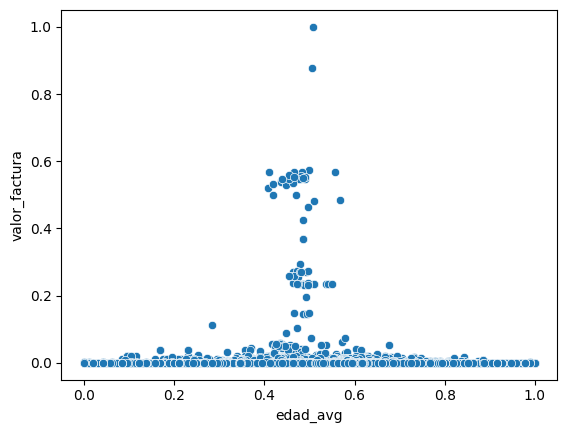

In [34]:
sns.scatterplot(transformed_data, x="edad_avg", y="valor_factura")
plt.show();

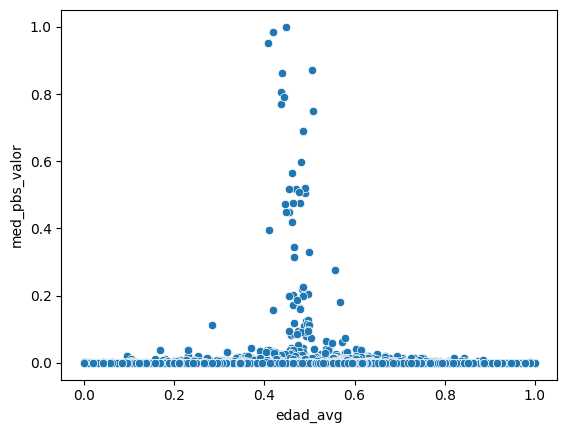

In [35]:
sns.scatterplot(transformed_data, x="edad_avg", y="med_pbs_valor")
plt.show();

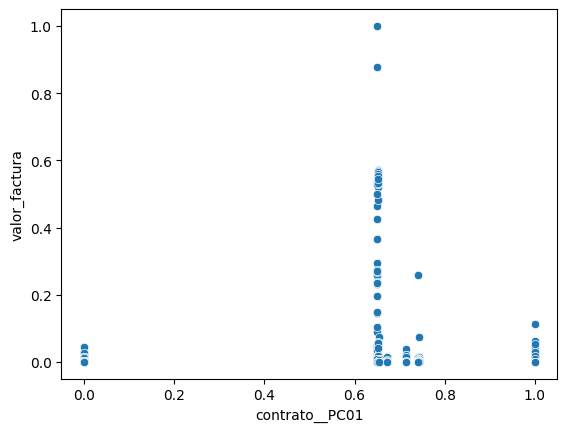

In [36]:
try:
    sns.scatterplot(transformed_data, x="contrato__PC01", y="valor_factura")
    plt.show();
except Exception as e:
    print("ERROR:", e)

# Obtener anomalias

In [37]:
contamination:float=0.01
anomaly_methods:list=["LOF", "IForest", "AutoEncoder"]
anomaly_threshold:float=0.3

In [38]:
%%time

## run detector
df_anom = run_anomaly_detectors(
        data=df
        , X=transformed_data.values
        , anomaly_methods=anomaly_methods
        , contamination=contamination
        , anomaly_threshold=anomaly_threshold
)

11282/11282 [==============================] - 12s 1ms/step
CPU times: total: 2h 2min 3s
Wall time: 51min 19s


In [39]:
fName = f"./output/{prestador}/df_anom.parquet"
df_anom.to_parquet(fName)
print(f"{fName=}\n{df_anom.shape=}")
df_anom.head()

fName='./output/0DD90F985DE9C9863A8073BB6BEDBED0/df_anom.parquet'
df_anom.shape=(361018, 58)


,periodo_fin_ano,periodo_fin_mes,duracion_facturacion,contrato,valor_copago,valor_descuentos,valor_factura,personas_unicas,mujeres,hombres,personas_rural,personas_c,edad_avg,edad_std,edad_p50,reg_med,personas_unicas_con_med,mujeres_con_med,menores_con_med,avg_personas_con_med,num_med_mujeres,num_med_menores,num_med_rurales,num_med,num_med_nopbs,med_pbs_cantidad,avg_med_pbs_cantidad,std_med_pbs_cantidad,p50_med_pbs_cantidad,med_pbs_valor,avg_med_pbs_valor,std_med_pbs_valor,p50_med_pbs_valor,med_nopbs_cantidad,avg_med_nopbs_cantidad,std_med_nopbs_cantidad,p50_med_nopbs_cantidad,med_nopbs_valor,avg_med_nopbs_valor,std_med_nopbs_valor,p50_med_nopbs_valor,LOF,LOF__score,LOF__prob,IForest,IForest__score,IForest__prob,AutoEncoder,AutoEncoder__score,AutoEncoder__prob,Ensamble,Ensamble__prob,Ensamble__prob_std,Ensamble P(0.3),Ensamble__pos,AutoEncoder__pos,IForest__pos,LOF__pos
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D1705BF90ACB4583339A5F6BBED5A4C5-852126,2021,10,0.032856,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,87192.0,307,187,120,0,0,54.110749,25.268637,61.0,1,1,0,0,44.0,0,0,0,1,0,56.0,56.0,0.0,56.0,87192.0,1557.0,0.000000,1557.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.009916,9.555125e-11,0,-0.200977,0.105152,0,3.430549,0.002622,0,0.035925,0.059967,0,185593,180962,185213,231322
370E0DD7AE83F3537F02F2AA80E1DD24-556158,2021,2,1.905540,FE63394A58C6DBE758731799A1022802,0.0,0.0,113220.0,1408,888,520,0,0,47.657670,25.696537,55.0,1,1,1,0,90.0,1,0,0,1,0,30.0,30.0,0.0,30.0,113220.0,3774.0,0.000000,3774.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.128036,1.585467e-10,0,-0.202210,0.102487,0,3.372106,0.002556,0,0.035014,0.058447,0,189103,186517,188816,96851
1F9AA689BB1B03F4E8469A896BC67AE5-506452,2021,1,4.665300,4B9BB01F3B4C1344BF7C4B4DBD9F3E6D,0.0,0.0,4775.0,2467,1475,992,0,0,50.287799,24.300061,57.0,2,1,1,1,1.0,2,2,0,2,0,2.0,1.0,0.0,1.0,4775.0,2387.5,543.765115,2387.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.989933,8.489401e-11,0,-0.087649,0.350185,0,5.973472,0.005503,0,0.118563,0.200610,0,20190,40058,20007,304337
6451E795C14D1EC5611DE4E8693C4D41-729094,2021,8,0.032856,FE63394A58C6DBE758731799A1022802,0.0,0.0,90188.0,466,287,179,0,36,57.006438,19.449907,61.0,1,1,1,0,69.0,1,0,0,1,0,28.0,28.0,0.0,28.0,90188.0,3221.0,0.000000,3221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.053736,1.189213e-10,0,-0.247185,0.005243,0,1.520225,0.000458,0,0.001900,0.002904,0,358793,357631,358570,154466
4210F933D2F6EC5DA10527BE5144A58A-567105,2021,3,4.895280,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,184380.0,1434,903,531,0,0,58.251046,25.342368,65.0,1,1,1,0,86.0,1,0,0,1,0,28.0,28.0,0.0,28.0,184380.0,6585.0,0.000000,6585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.395517,3.011996e-10,0,-0.176157,0.158818,0,4.331038,0.003642,0,0.054153,0.090660,0,111324,113773,111221,33629


In [40]:
## agrega resultado al df de origen

df = add_anomaly_2_raw(raw=raw, transformed_data=transformed_data, df_anom=df_anom)
fName = f"./output/{prestador}/df.parquet"
df.to_parquet(fName)
print(f"Resultado del procesamiento guardado en {fName=}\n{df.shape=}")
df.head()

Resultado del procesamiento guardado en fName='./output/0DD90F985DE9C9863A8073BB6BEDBED0/df.parquet'
df.shape=(361018, 61)


,periodo_fin_ano,periodo_fin_mes,duracion_facturacion,contrato,valor_copago,valor_descuentos,valor_factura,personas_unicas,mujeres,hombres,personas_rural,personas_c,edad_avg,edad_std,edad_p50,reg_med,personas_unicas_con_med,mujeres_con_med,menores_con_med,avg_personas_con_med,num_med_mujeres,num_med_menores,num_med_rurales,num_med,num_med_nopbs,med_pbs_cantidad,avg_med_pbs_cantidad,std_med_pbs_cantidad,p50_med_pbs_cantidad,med_pbs_valor,avg_med_pbs_valor,std_med_pbs_valor,p50_med_pbs_valor,med_nopbs_cantidad,avg_med_nopbs_cantidad,std_med_nopbs_cantidad,p50_med_nopbs_cantidad,med_nopbs_valor,avg_med_nopbs_valor,std_med_nopbs_valor,p50_med_nopbs_valor,contrato__pc01,contrato__pc02,contrato__pc03,lof,lof__score,lof__prob,iforest,iforest__score,iforest__prob,autoencoder,autoencoder__score,autoencoder__prob,ensamble,ensamble__prob,ensamble__prob_std,ensamble_p_0_3,ensamble__pos,autoencoder__pos,iforest__pos,lof__pos
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D1705BF90ACB4583339A5F6BBED5A4C5-852126,2021,10,0.032856,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,87192.0,307,187,120,0,0,54.110749,25.268637,61.0,1,1,0,0,44.0,0,0,0,1,0,56.0,56.0,0.0,56.0,87192.0,1557.0,0.000000,1557.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,5.242673e-11,0.488176,0,1.009916,9.555125e-11,0,-0.200977,0.105152,0,3.430549,0.002622,0,0.035925,0.059967,0,185593,180962,185213,231322
370E0DD7AE83F3537F02F2AA80E1DD24-556158,2021,2,1.905540,FE63394A58C6DBE758731799A1022802,0.0,0.0,113220.0,1408,888,520,0,0,47.657670,25.696537,55.0,1,1,1,0,90.0,1,0,0,1,0,30.0,30.0,0.0,30.0,113220.0,3774.0,0.000000,3774.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.551115e-17,4.155472e-01,0.493691,0,1.128036,1.585467e-10,0,-0.202210,0.102487,0,3.372106,0.002556,0,0.035014,0.058447,0,189103,186517,188816,96851
1F9AA689BB1B03F4E8469A896BC67AE5-506452,2021,1,4.665300,4B9BB01F3B4C1344BF7C4B4DBD9F3E6D,0.0,0.0,4775.0,2467,1475,992,0,0,50.287799,24.300061,57.0,2,1,1,1,1.0,2,2,0,2,0,2.0,1.0,0.0,1.0,4775.0,2387.5,543.765115,2387.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.132168e-01,8.313995e-01,0.529178,0,0.989933,8.489401e-11,0,-0.087649,0.350185,0,5.973472,0.005503,0,0.118563,0.200610,0,20190,40058,20007,304337
6451E795C14D1EC5611DE4E8693C4D41-729094,2021,8,0.032856,FE63394A58C6DBE758731799A1022802,0.0,0.0,90188.0,466,287,179,0,36,57.006438,19.449907,61.0,1,1,1,0,69.0,1,0,0,1,0,28.0,28.0,0.0,28.0,90188.0,3221.0,0.000000,3221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,4.155472e-01,0.493691,0,1.053736,1.189213e-10,0,-0.247185,0.005243,0,1.520225,0.000458,0,0.001900,0.002904,0,358793,357631,358570,154466
4210F933D2F6EC5DA10527BE5144A58A-567105,2021,3,4.895280,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,184380.0,1434,903,531,0,0,58.251046,25.342368,65.0,1,1,1,0,86.0,1,0,0,1,0,28.0,28.0,0.0,28.0,184380.0,6585.0,0.000000,6585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,0.000000e+00,0.488176,0,1.395517,3.011996e-10,0,-0.176157,0.158818,0,4.331038,0.003642,0,0.054153,0.090660,0,111324,113773,111221,33629


In [41]:
print(f"""Max value of ensamble__prob = {df["ensamble__prob"].max():,.2%}""")

Max value of ensamble__prob = 63.96%


In [42]:
me = anomaly_methods[0]
df.sort_values(f"{me.lower()}__pos").head()[[c for c in df if c.startswith(me.lower())]].iloc[0]

lof           1.000000e+00
lof__score    1.776364e+09
lof__prob     9.473684e-01
lof__pos      1.000000e+00
Name: FA77382ADC74AC20C40211D024049C98-485469, dtype: float64

,count,proportion
edad_avg,,
0.0,13,0.000036
1.0,43,0.000119
1.5,2,0.000006
2.0,36,0.000100
3.0,25,0.000069
...,...,...
91.0,4,0.000011
92.0,2,0.000006
93.0,8,0.000022


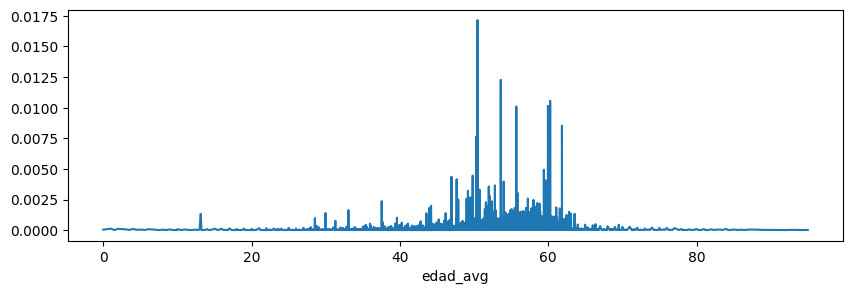

In [43]:
df["edad_avg"].value_counts(normalize=True).sort_index().plot(figsize=(10,3))
pd.concat([df["edad_avg"].value_counts().sort_index(), df["edad_avg"].value_counts(normalize=True).sort_index()], axis=1)

In [ ]:
## load data
fName = f"./output/{prestador}/df.parquet"
df = pd.read_parquet(fName)
print(df.shape)
df.head()

(424615, 136)


,id,factura,id_carga,prestador,periodo_fin_ano,periodo_fin_mes,duracion_facturacion,regimen,contrato,valor_copago,valor_comision,valor_descuentos,valor_factura,personas_unicas,mujeres,hombres,personas_rural,personas_c,personas_victima,edad_avg,edad_std,edad_p50,reg_consultas,personas_unicas_con_consultas,mujeres_con_consultas,menores_con_consultas,avg_personas_con_consultas,num_consultas_mujeres,num_consultas_menores,num_consultas_rurales,num_consultas_dx_conf,cod_consultas_unicos,dx_consulta_unicos,sum_valor_consultas,avg_por_consulta,reg_proced,personas_unicas_con_proced,mujeres_con_proced,menores_con_proced,avg_personas_con_proced,num_proced_mujeres,num_proced_menores,num_proced_rurales,cod_proced_unicos,proced_ambito_hosp,proced_ambito_urg,proced_para_dx,proced_para_terapia,proced_medico,proced_con_complicaciones,sum_valor_proced,avg_valor_prom,reg_urg,personas_unicas_con_urg,mujeres_con_urg,menores_con_urg,avg_personas_con_urg,num_urg_mujeres,num_urg_menores,num_urg_rurales,num_ingresos_urg,avg_estancia_urg,personas_fallecidas_urg,reg_hosp,personas_unicas_con_hosp,mujeres_con_hosp,menores_con_hosp,avg_personas_con_hosp,num_hosp_mujeres,num_hosp_menores,num_hosp_rurales,num_hosp,avg_estancia_hosp,std_estancia_hosp,p50_estancia_hosp,personas_fallecidas_hosp,reg_nac,personas_unicas_con_nac,mujeres_con_nac,menores_con_nac,avg_personas_con_nac,num_nac_mujeres,num_nac_menores,num_nac_rurales,num_rn_mujeres,avg_edad_gest,std_edad_gest,avg_peso_rn,std_peso_rn,num_nac_vivo,reg_med,personas_unicas_con_med,mujeres_con_med,menores_con_med,avg_personas_con_med,num_med_mujeres,num_med_menores,num_med_rurales,num_med,num_med_nopbs,med_pbs_cantidad,avg_med_pbs_cantidad,std_med_pbs_cantidad,p50_med_pbs_cantidad,med_pbs_valor,avg_med_pbs_valor,std_med_pbs_valor,p50_med_pbs_valor,med_nopbs_cantidad,avg_med_nopbs_cantidad,std_med_nopbs_cantidad,p50_med_nopbs_cantidad,med_nopbs_valor,avg_med_nopbs_valor,std_med_nopbs_valor,p50_med_nopbs_valor,lof,lof_pos,lof_prob,lof_score,iforest,iforest_pos,iforest_prob,iforest_score,autoencoder,autoencoder_pos,autoencoder_prob,autoencoder_score,ensamble,ensamble_p_0_3,ensamble_pos,ensamble_prob,ensamble_prob_std,ensamble_max_prob,ensamble_max_pos,prestador_procesado
0,0A63F73BBCAC26F50F6BC4B4BE667645-1047039,0A63F73BBCAC26F50F6BC4B4BE667645,1047039,0DD90F985DE9C9863A8073BB6BEDBED0,2022,2,0.032856,S,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,0.0,247380.0,28,22,6,0,0,0,46.750000,32.344929,46.5,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0.000000,0,0,0,0,0,0.0,0,0,0,0,0.000000,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,E3AA3A1DD85EC115044C37F6997FDF51-1109850,E3AA3A1DD85EC115044C37F6997FDF51,1109850,0DD90F985DE9C9863A8073BB6BEDBED0,2022,3,0.032856,S,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,0.0,434460.0,291,194,97,0,0,0,49.295533,32.914025,59.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0.000000,0,0,0,0,0,0.0,0,0,0,0,0.000000,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,741E66268E21771320871226A20ACCC0-1376511,741E66268E21771320871226A20ACCC0,1376511,0DD90F985DE9C9863A8073BB6BEDBED0,2022,10,0.032856,S,7FC4473135FD6CA92BD5C1AE4243A35A,0.0,0.0,0.0,323585.0,279,180,99,0,13,0,48.258065,33.479588,55.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0.000000,0,0,0,0,0,0.0,0,0,0,0,0.000000,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,02B66D71E3889FDE8F639321BA04E120-171990

# Envia a Snowflake

In [ ]:
from datatools.snowflake.DataFrame import Df2DFSnow
#from datatools.snowflake.Querys import run_sql_query

In [ ]:
## load data
fName = f"./output/{prestador}/{prestador}.parquet"
df = pd.read_parquet(fName)
print(df.shape)
df.head()

In [32]:
Df2DFSnow(df=df, table_name=f"t__{prestador}", database="vp_informacion", schema="outliers", mode="overwrite")

'vp_informacion.outliers.t__0DD90F985DE9C9863A8073BB6BEDBED0'

In [45]:
run_time(start_i)

Tiempo de ejecucion total: 52.58min.
Fecha de ejecucion: 2025-06-07 10:25:55.129133
